<a href="https://colab.research.google.com/github/wzljerry/Blockchain-based-Edge-Resource-Sharing-for-Metaverse/blob/main/QL_Task_Allocation_MEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
'''
@Title : Q_learning based solution of mutiple knapsacks problem
@Author : Zhilin Wang
@Email : wangzhil@iu.edu
@Date : 14-04-2022
'''
#import tensorflow as tf
#tf.test.gpu_device_name()
import numpy as np
import pandas as pd
import math
import time
import random
from random import choice
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(1)

In [2]:
#generate data
class DataCollection:
  def __init__(self):
    pass
  
  #get random value
  def generate_random_value(self,low,up,num):
    randomlist = []
    for i in range(num):
      n = random.randint(low,up)
      randomlist.append(n)
    return randomlist

  #generate task
  def generate_task(self,p,D,T,num):
    task=[]
    for i in range(num):
      a=[p[i],D[i],T[i]]
      task.append(a)
    return task
  
  #generate server
  def generate_server(self,low,up,num):
    server=self.generate_random_value(low,up,num)
    return server

  #generate group
  def generate_group(self,num_task,num_server):
    num=[i for i in range(num_task)]
    shuffle(num)
    group_task=np.array_split(num,num_server)
    for i in range(num_server):
      group_task[i]=list(group_task[i])
    return group_task

In [3]:
class Task_allocation:
  # parameters
  #task is a matrix which contains [price p_j, data size D_j, executing time t_e]
  #server is a list, which contains the computational powers for each server
  def __init__(self,f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta, task,server,ser_task,ALPHA,GAMMA,EPSILON,MAX_EPISODES):
    self.task=task
    self.lamda=0.01
    self.ser_task=ser_task
    self.server=server
    self.m=task.shape[0] #number of tasks
    self.n=len(server) #number of servers
    self.B=B #bandwidth
    self.delta=0.001 #gussian noise
    self.alpha=alpha #CPU parameter
    self.P_i=P_i #trainsimission power
    self.G_i=G_i #trainsimission gain
    self.f_j=f_j #CPU frequency
    self.d_i=d_i # sample cpu cyecles
    self.R_i_j=R_i_j
    self.N_STATES = self.m   # number of states
    self.ACTIONS = [i for i in range(self.n)]     # action
    self.EPSILON = EPSILON  # greedy
    self.ALPHA = ALPHA     # learning rate
    self.GAMMA = GAMMA    # discount
    self.MAX_EPISODES = MAX_EPISODES
    self.q_table=self.build_q_table()# q_table

  #generate values which can be repeated
  def generate_random_value(self,low,up,num):
    randomlist = []
    for i in range(num):
      n = random.randint(low,up)
      randomlist.append(n)
    return randomlist  

  # create the q_table with initial value=0
  def build_q_table(self):
    q_table = pd.DataFrame(
        np.zeros((self.N_STATES, len(self.ACTIONS))),     # initialize q_table
        columns=self.ACTIONS,    # columns, the name of actions
    )
    return q_table
  
  #check whether the server i can process task j with cpu and time constraints
  def check_avaliable(self,j,i,h):
    res=0
    if self.task[j][1]*self.d_i[i]<self.server[i]: #cpu
      if (self.task[j]*self.d_i[i]/self.f_j[i]+self.task[j][1]/self.R_i_j[h]).all()<self.task[j][2]: #time
        res=1
    return res

  #if j is from i, then no transimision
  def check_avaliable_1(self,j,i):
    res=0
    if self.task[j][1]*self.d_i[i]<self.server[i]: #cpu
      if (self.task[j]*self.d_i[i]/self.f_j[i]).all()<self.task[j][2]:#time
          res=1
    return res


  def find_source(self,j):
    for com in self.ser_task:
      if j in com:
        index = com.index(j) 
    return index

  #check whether task j is from server i
  def check_source(self,task_num,group_num):
    group=self.ser_task[group_num] # group
    res=0
    if task_num in group: #in or not
      res=1
    return res

  #get the reward based on sources and avaliability
  def get_feedback(self):
    rew=[]
    for j in range(self.m): # for each task
      for i in range(self.n): # for each server
        if self.check_source(j,i)==1: # in that group
          #h=i
          if self.check_avaliable_1(j,i)==1: # avaliable
            reward=self.task[j][0]*self.task[j][1]*self.d_i[i] 
            -self.alpha*self.task[j][1]*self.d_i[i]*self.f_j[i]**2 # only need to compute
          else:
            reward=-self.task[j][1]/self.R_i_j[i]*self.P_i[i]+self.lamda*self.task[j][0]*self.task[j][1]*self.d_i[i] # only need to transimist
        if self.check_source(j,i)!=1: # not in that group
          h=self.find_source(j)
          if self.check_avaliable(j,i,h)==1: # avaliable
            reward=self.task[j][0]*self.task[j][1]*self.d_i[i]
            -self.alpha*self.task[j][1]*self.d_i[i]*self.f_j[i]**2-self.lamda*self.task[j][0]*self.task[j][1]*self.d_i[i] # needs to compute
          else:
            reward=0 # get nothing because it can't process task j
        rew.append(reward) # using a list to contain all the rewards for each task and each server
    return rew

  #to get the avaliable actions set for each task
  def check_action_reward(self,task_num):
    reward=self.get_feedback()
    reward=np.array(reward).reshape(self.m,self.n) # using a m*n matrix to contain the rewards
    index_list=[] 
    for i in range(self.n): #for each server
      if reward[task_num][i]!=0: # if =0, the server can't process that task
        action_index=i
        index_list.append(action_index)
    return index_list # return the avaliable index of actions


    #to get the avaliable actions set for each task without speed up
  def check_action_reward_without_speed_up(self,task_num):
    reward=self.get_feedback()
    reward=np.array(reward).reshape(self.m,self.n) # using a m*n matrix to contain the rewards
    index_list=[] 
    for i in range(self.n): #for each server
      #if reward[task_num][i]!=0: # if =0, the server can't process that task
      action_index=i
      index_list.append(action_index)
    return index_list # return the avaliable index of actions

  def select_action(self,task_num,state_actions):
    #state_actions = self.check_action_reward(task_num)
    if (np.random.uniform() > self.EPSILON) or (len(state_actions) == 0): 
    #if np.random.uniform() > self.EPSILON:  # not greedy
      #action_name = np.random.choice(state_actions)
      action_name =choice(state_actions)

    else:
      q_value=pd.DataFrame(self.q_table.loc[task_num,state_actions]).T
      action_name = int(q_value.idxmax(axis=1))   # greedy
    return action_name
  
  #create a table to contain the cpu capacity
  def cpu_table(self):
    cpu_table=self.build_q_table()
    return cpu_table
  
  #create a table to contain the time
  def time_table(self):
    time_table=self.build_q_table()
    return time_table


  def check_action_valid(self,j,actions_ava,rewards,cpu_table,time_table,state_actions,action,acc_mu,acc_t):
    res=True
    if action in actions_ava: # select actions in avaliable sets
      if (acc_mu>self.server[action] or acc_t< self.task[j][2]): # satisify that the cpu and time are both enough
        state_actions.remove(action) # remove that action
        action=self.select_action(j,state_actions)
        if (acc_mu>self.server[action] or acc_t< self.task[j][2]):
          action=self.check_action_valid(j,actions_ava,rewards,cpu_table,time_table,state_actions,action,acc_mu,acc_t)
      else:
        actions_ava.append(action)
    return action


  def q_update_modified(self):
    actions_ava=[]
    rews=[]
    act=[]
    rewards=np.array(self.get_feedback()).reshape(self.m,self.n)
    cpu_table=self.cpu_table()
    time_table=self.time_table()
    # check the limitation of time and cpu
    for j in range(self.m):
      state_actions = self.check_action_reward(j)
      action=self.select_action(j,state_actions)
      #initialize acc_t and acc_mu
      acc_mu=cpu_table[action].sum() # sum of cpu
      acc_t=(self.server[action]-acc_mu)/self.f_j[action]
      action=self.check_action_valid(j,actions_ava,rewards,cpu_table,time_table,state_actions,action,acc_mu,acc_t)

      # record the cpu and time
      cpu_table[action][j]=self.task[j][1]
      acc_mu=cpu_table[action].sum() # sum of cpu

      #update q
      if j != self.m-1:
        self.q_table.iloc[j,action] += self.ALPHA*(rewards[j][action]
                                                   +self.GAMMA*np.max(self.q_table.iloc[j+1,state_actions])-self.q_table.iloc[j,action])
      else:
        self.q_table.iloc[j,action] += self.ALPHA*(rewards[j][action]
                                                 +self.GAMMA*np.max(self.q_table.iloc[j,state_actions])-self.q_table.iloc[j,action])
      rew=rewards[j][action]# the rewards of each step
      rews.append(rew) # rewads for all the tasks
      act.append(action) #action set
    res=sum(rews)#total rewards for one tempt
    return self.q_table,res,act

  #update q_table
  def q_update(self):
    actions_ava=[]
    rews=[]
    act=[]
    rewards=np.array(self.get_feedback()).reshape(self.m,self.n)
    cpu_table=self.cpu_table()
    time_table=self.time_table()
    # check the limitation of time and cpu
    for j in range(self.m):
      state_actions = self.check_action_reward(j)
      action=self.select_action(j,state_actions)
      #initialize acc_t and acc_mu
      acc_mu=cpu_table[action].sum() # sum of cpu
      acc_t=(self.server[action]-acc_mu)/self.f_j[action]
      if action in actions_ava: # select actions in avaliable sets
        if (acc_mu>self.server[action] or acc_t< self.task[j][2]): # satisify that the cpu and time are both enough
          state_actions.remove(action) # remove that action
          action=self.select_action(j,state_actions) # reselect another action
      else:
        actions_ava.append(action)

      # record the cpu and time
      cpu_table[action][j]=self.task[j][1]
      acc_mu=cpu_table[action].sum() # sum of cpu

      #update q
      if j != self.m-1:
        self.q_table.iloc[j,action] += self.ALPHA*(rewards[j][action]
                                                   +self.GAMMA*np.max(self.q_table.iloc[j+1,state_actions])-self.q_table.iloc[j,action])
      else:
        self.q_table.iloc[j,action] += self.ALPHA*(rewards[j][action]
                                                 +self.GAMMA*np.max(self.q_table.iloc[j,state_actions])-self.q_table.iloc[j,action])
      rew=rewards[j][action]# the rewards of each step
      rews.append(rew) # rewads for all the tasks
      act.append(action) #action set
    res=sum(rews)#total rewards for one tempt
    return self.q_table,res,act

    #update q_table 
  def q_update_without_speed_up(self):
    actions_ava=[]
    rews=[]
    act=[]
    rewards=np.array(self.get_feedback()).reshape(self.m,self.n)
    cpu_table=self.cpu_table()
    time_table=self.time_table()
    # check the limitation of time and cpu
    for j in range(self.m):
      state_actions = self.check_action_reward_without_speed_up(j)
      action=self.select_action(j,state_actions)
      #initialize acc_t and acc_mu
      acc_mu=cpu_table[action].sum() # sum of cpu
      acc_t=(self.server[action]-acc_mu)/self.f_j[action]
      action=self.check_action_valid(j,actions_ava,rewards,cpu_table,time_table,state_actions,action,acc_mu,acc_t)
      # record the cpu and time
      cpu_table[action][j]=self.task[j][1]
      acc_mu=cpu_table[action].sum() # sum of cpu

      #update q
      if j != self.m-1:
        self.q_table.iloc[j,action] += self.ALPHA*(rewards[j][action]
                                                   +self.GAMMA*np.max(self.q_table.iloc[j+1,state_actions])-self.q_table.iloc[j,action])
      else:
        self.q_table.iloc[j,action] += self.ALPHA*(rewards[j][action]
                                                 +self.GAMMA*np.max(self.q_table.iloc[j,state_actions])-self.q_table.iloc[j,action])
      rew=rewards[j][action]# the rewards of each step
      rews.append(rew) # rewads for all the tasks
      act.append(action) #action set
    res=sum(rews)#total rewards for one tempt
    return self.q_table,res,act
  
  #get the index based on greedy
  def greedy_reward(self,j,rewards):
    rewards=pd.DataFrame(rewards)
    index=self.check_action_reward(j)
    reward=rewards.iloc[j,index]
    max_reward=max(list(reward))
    max_index=list(reward).index(max_reward)
    return max_index

  #get the rewards by greedy search
  def greedy_select(self):
    actions_ava=[]
    rews=[]
    act=[]
    rewards=np.array(self.get_feedback()).reshape(self.m,self.n)
    cpu_table=self.cpu_table()
    time_table=self.time_table()
    # check the limitation of time and cpu
    for j in range(self.m):
      state_actions = self.check_action_reward(j)
      action=self.greedy_reward(j,rewards)
      #initialize acc_t and acc_mu
      acc_mu=cpu_table[action].sum() # sum of cpu
      acc_t=(self.server[action]-acc_mu)/self.f_j[action]
      if action in actions_ava: # select actions in avaliable sets
        if (acc_mu>self.server[action] or acc_t< self.task[j][2]): # satisify that the cpu and time are both enough
          state_actions.remove(action) # remove that action
          action=self.select_action(j,state_actions) # reselect another action
      else:
        actions_ava.append(action)

      # record the cpu and time
      cpu_table[action][j]=self.task[j][1]
      acc_mu=cpu_table[action].sum() # sum of cpu

      res=rewards[j][action]
      rews.append(res)
    rews_sum=sum(rews)
    return rews_sum

  # get the index randomly selected  
  def random_index(self,j,rewards):
    rewards=pd.DataFrame(rewards)
    #for j in range(self.m):
    index=self.check_action_reward(j)
    reward=rewards.iloc[j,index]
    random_reward=choice(list(reward))
    random_index=list(reward).index(random_reward)
    return random_index

  #get the rewards by random strategy
  def ramdom_select(self):
    actions_ava=[]
    rews=[]
    act=[]
    rewards=np.array(self.get_feedback()).reshape(self.m,self.n)
    cpu_table=self.cpu_table()
    time_table=self.time_table()
    # check the limitation of time and cpu
    for j in range(self.m):
      state_actions = self.check_action_reward(j)
      action=self.random_index(j,rewards)
      #initialize acc_t and acc_mu
      acc_mu=cpu_table[action].sum() # sum of cpu
      acc_t=(self.server[action]-acc_mu)/self.f_j[action]

      if action in actions_ava: # select actions in avaliable sets
        if (acc_mu>self.server[action] or acc_t< self.task[j][2]): # satisify that the cpu and time are both enough
          state_actions.remove(action) # remove that action
          action=self.select_action(j,state_actions) # reselect another action
      else:
        actions_ava.append(action)

      # record the cpu and time
      cpu_table[action][j]=self.task[j][1]
      acc_mu=cpu_table[action].sum() # sum of cpu

      res=rewards[j][action]
      rews.append(res)
    rews_sum=sum(rews)
    return rews_sum
  
  #training with speed up
  def training(self):
    res=[]
    act=[]
    #training
    for i in range(self.MAX_EPISODES):
      q_table,reward,actions=self.q_update_modified()
      res.append(reward)
      act.append(actions)
    max_reward=np.max(res)
    best_solution=act[res.index(np.max(res))]
    index_list=[j for j in range(self.m)]
    best_server_task=list(zip(index_list,best_solution)) # the best allocation
    return max_reward,best_server_task,q_table,res

  #training without speed up
  def training_without_speed_up(self):
    res=[]
    act=[]
    #training
    for i in range(self.MAX_EPISODES):
      q_table,reward,actions=self.q_update_without_speed_up()
      res.append(reward)
      act.append(actions)
    max_reward=np.max(res)
    best_solution=act[res.index(np.max(res))]
    index_list=[j for j in range(self.m)]
    best_server_task=list(zip(index_list,best_solution)) # the best allocation
    return max_reward,best_server_task,q_table,res

In [ ]:
if __name__=='__main__':
  #parameters
  num_server=20#number of servers
  num_task=50#number of tasks
  EPSILON=0.9 # greedy
  GAMMA=0.9 #discount
  ALPHA=0.01 #learning rate
  max_iteration=500#iterations
  #generate data
  data=DataCollection()
  p=data.generate_random_value(1,10,num_task) #price
  D=data.generate_random_value(10,20,num_task) #data size
  T=data.generate_random_value(1,100,num_task) #time
  task=data.generate_task(p,D,T,num_task) #tasks
  task=np.array(task) 
  ser_task=data.generate_group(num_task,num_server) #server-class group
  server=data.generate_server(200,400,num_server) #server
  f_j=data.generate_random_value(1,10,num_server) #CPU frequency
  d_i=data.generate_random_value(1,10,num_server)
  alpha=0.00001
  B=data.generate_random_value(5,10,num_server)
  P_i=data.generate_random_value(5,10,num_server)
  G_i=data.generate_random_value(5,10,num_server)
  delta=0.001
  R_i_j=[]
  for i in range(num_server):
    R=B[i]*math.log(1+(P_i[i]*G_i[i])/delta**2)
    R_i_j.append(R)

  #training
  #self,f_j, d_i, alpha, B, P_i, G_i, task,server,ser_task,ALPHA,GAMMA,EPSILON,MAX_EPISODES
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,max_iteration)
  #random
  max_random=ql.ramdom_select()
  print(max_random)
  #greedy
  max_greedy=ql.greedy_select()
  print(max_greedy)
  #q_learning
  max_reward,solution,q_table,res=ql.training()
  solution=np.array(solution)
  #print(solution)
  print(max_reward)
  print(res)
  #print(q_table)


17396.0
16107.0


In [ ]:
S=[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
rew_f=[]
for s in S:
  f_j=[1, 5, 8, 6, 4, 1, 10, 4, 9, 5, 9, 4, 10, 1, 8, 2, 5, 8, 1, 2]
  f_i=[i*s for i in S]
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,1)
  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  rew_f.append(max_reward)

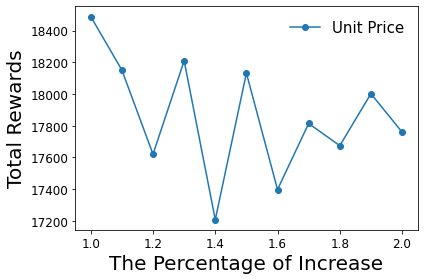

In [ ]:
k=np.arange(1,2.01,0.1)
plt.plot(k,rew_f,'o',markevery=1,ls='-',label='Unit Price')
#plt.plot(k,rew_d,'o',markevery=1,ls='-',label='Data Size')
#plt.plot(k,rew_t,'o',markevery=1,ls='-')
#plt.plot(k,b/10,'o',markevery=1,ls='-',label='Without')
plt.xlabel("The Percentage of Increase",fontsize=20) 
plt.ylabel("Total Rewards",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test_para.pdf')
plt.show()

In [ ]:
S=[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
rew_d=[]
for s in S:
  f_j=[7, 1, 4, 5, 1, 9, 5, 1, 9, 1, 1, 2, 5, 8, 7, 7, 2, 7, 4, 9]
  f_i=[i*s for i in S]

  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,1)
  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  rew_d.append(max_reward)

In [ ]:
S=[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
rew_d=[]
for s in S:
  D=[20, 14, 15, 12, 19, 14, 19, 12, 19, 17, 19, 10, 12, 15, 15, 20, 14, 14, 13, 10, 17, 12, 16, 15, 19, 10, 10, 11, 16, 18, 17, 15, 19, 19, 11, 20, 19, 12, 19, 14, 10, 18, 19, 12, 17, 12, 17, 17, 20, 15]
  D_i=[i*s for i in p]
  task=data.generate_task(p,D_i,T,num_task) #tasks
  task=np.array(task)

  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,1)
  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  rew_d.append(max_reward)
  

In [ ]:
S=[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
rew_p=[]
for s in S:
  p=[10, 5, 7, 9, 4, 9, 10, 1, 2, 7, 9, 10, 3, 7, 6, 10, 9, 4, 10, 8, 1, 7, 9, 1, 1, 5, 6, 6, 1, 2, 3, 3, 2, 8, 6, 9, 2, 3, 1, 3, 2, 9, 6, 2, 2, 2, 9, 5, 6, 5]
  p_i=[i*s for i in p]
  task=data.generate_task(p_i,D,T,num_task) #tasks
  task=np.array(task)

  R_i_j=[]
  for i in range(num_server):
    R=B[i]*math.log(1+(P_i[i]*G_i[i])/delta**2)
    R_i_j.append(R)

  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,1)
  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  rew_p.append(max_reward)

In [ ]:
S=[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
p=[5, 6, 1, 10, 2, 1, 9, 9, 8, 8, 2, 5, 5, 8, 6, 6, 4, 2, 8, 4, 9, 9, 10, 5, 4, 5, 2, 3, 3, 5, 6, 9, 6, 1, 10, 7, 6, 6, 3, 8, 7, 8, 6, 3, 3, 6, 3, 1, 5, 4]
rew_t=[]
for s in S:
  T=[44, 6, 77, 53, 87, 49, 13, 41, 46, 63, 53, 40, 89, 89, 25, 16, 16, 24, 38, 62, 68, 33, 42, 6, 94, 51, 88, 32, 93, 89, 3, 55, 84, 81, 90, 95, 28, 83, 16, 44, 15, 92, 66, 84, 92, 80, 80, 89, 91, 79]
  
  T_1=[i*s for i in T]
  task=data.generate_task(p,D,T_1,num_task) #tasks
  task=np.array(task)


  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,max_iteration)
  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  rew_t.append(max_reward)

No handles with labels found to put in legend.


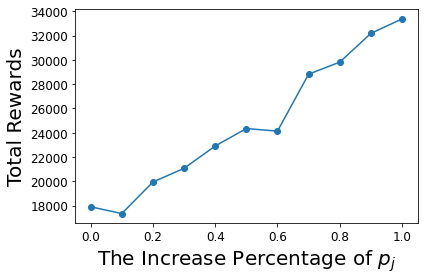

In [ ]:
k=np.arange(0,1.01,0.1)
plt.plot(k,rew_p,'o',markevery=1,ls='-')
#plt.plot(k,rew_t,'o',markevery=1,ls='-')
#plt.plot(k,b/10,'o',markevery=1,ls='-',label='Without')
plt.xlabel("The Increase Percentage of $p_j$",fontsize=20) 
plt.ylabel("Total Rewards",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test_para_1.pdf')
plt.show()

No handles with labels found to put in legend.


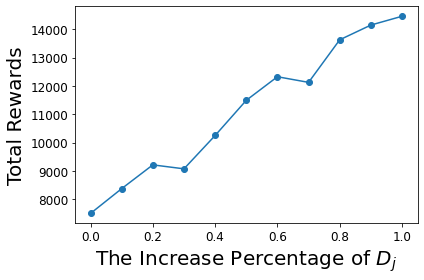

In [ ]:
k=np.arange(0,1.01,0.1)
plt.plot(k,rew_d,'o',markevery=1,ls='-')
#plt.plot(k,rew_t,'o',markevery=1,ls='-')
#plt.plot(k,b/10,'o',markevery=1,ls='-',label='Without')
plt.xlabel("The Increase Percentage of $D_j$",fontsize=20) 
plt.ylabel("Total Rewards",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test_para_2.pdf')
plt.show()

In [ ]:
num_t=[50,60,70,80,90,100]
#num_s=[10,20,30,40,50,60]
num_s=[10,15,20,25,30,35,40,45,50,55]
time_count=[]
time_cout_1=[]
time_without=[]
time_without_1=[]
time_c=[]
#for i in range(5):
for num_server in num_s:
  num_task=50#number of tasks
  EPSILON=0.9 # greedy
  GAMMA=0.9 #discount
  ALPHA=0.01 #learning rate
  max_iteration=1#iterations
    #generate data
  data=DataCollection()
  p=data.generate_random_value(1,10,num_task) #price
  D=data.generate_random_value(10,20,num_task) #data size
  T=data.generate_random_value(1,50,num_task) #time
  task=data.generate_task(p,D,T,num_task) #tasks
  task=np.array(task) 
  ser_task=data.generate_group(num_task,num_server) #server-class group
  server=data.generate_server(50,60,num_server) #server
  f_j=data.generate_random_value(1,10,num_server) #CPU frequency
  d_i=data.generate_random_value(1,10,num_server)
  alpha=0.00001
  B=data.generate_random_value(5,10,num_server)
  P_i=data.generate_random_value(5,10,num_server)
  G_i=data.generate_random_value(5,10,num_server)
  delta=0.001
  R_i_j=[]
  for i in range(num_server):
    R=B[i]*math.log(1+(P_i[i]*G_i[i])/delta**2)
    R_i_j.append(R)

    #training
    #self,f_j, d_i, alpha, B, P_i, G_i, task,server,ser_task,ALPHA,GAMMA,EPSILON,MAX_EPISODES
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,max_iteration)
  #random

    

    #with speed up
  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  time_end=time.time()
  time_cost=time_end-time_start
  time_count.append(time_cost)

    #without speed up
  time_start=time.time()
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,1)
  max_reward,solution,q_table,res=ql.training_without_speed_up()
  time_end=time.time()
  time_cost=time_end-time_start
  time_without.append(time_cost)

In [ ]:
num_t=[50,60,70,80,90,100]
num_t=[50,55,60,65,70,75,80,85,90,95]
time_count=[]
time_cout_1=[]
time_without=[]
time_without_1=[]
time_c=[]
#for i in range(5):
for num_task in num_t:
  num_server=20#number of tasks
  EPSILON=0.9 # greedy
  GAMMA=0.9 #discount
  ALPHA=0.01 #learning rate
  max_iteration=1#iterations
    #generate data
  data=DataCollection()
  p=data.generate_random_value(1,10,num_task) #price
  D=data.generate_random_value(10,20,num_task) #data size
  T=data.generate_random_value(1,50,num_task) #time
  task=data.generate_task(p,D,T,num_task) #tasks
  task=np.array(task) 
  ser_task=data.generate_group(num_task,num_server) #server-class group
  server=data.generate_server(50,60,num_server) #server
  f_j=data.generate_random_value(1,10,num_server) #CPU frequency
  d_i=data.generate_random_value(1,10,num_server)
  alpha=0.00001
  B=data.generate_random_value(5,10,num_server)
  P_i=data.generate_random_value(5,10,num_server)
  G_i=data.generate_random_value(5,10,num_server)
  delta=0.001
  R_i_j=[]
  for i in range(num_server):
    R=B[i]*math.log(1+(P_i[i]*G_i[i])/delta**2)
    R_i_j.append(R)

    #training
    #self,f_j, d_i, alpha, B, P_i, G_i, task,server,ser_task,ALPHA,GAMMA,EPSILON,MAX_EPISODES
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,max_iteration)
  #random

    

    #with speed up
  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  time_end=time.time()
  time_cost=time_end-time_start
  time_count.append(time_cost)

    #without speed up
  time_start=time.time()
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,1)
  max_reward,solution,q_table,res=ql.training_without_speed_up()
  time_end=time.time()
  time_cost=time_end-time_start
  time_without.append(time_cost)

In [ ]:
print(time_count)
print(time_without)

[1.018019199371338, 1.2231674194335938, 1.3748435974121094, 2.1571991443634033, 2.5641987323760986, 2.520216941833496, 3.3223206996917725, 3.7048656940460205, 3.8788836002349854, 4.914473056793213]
[0.8983602523803711, 1.30841064453125, 1.3937478065490723, 2.1218392848968506, 2.5822644233703613, 2.464726209640503, 3.6647558212280273, 3.861833095550537, 3.8668789863586426, 4.9961936473846436]


No handles with labels found to put in legend.


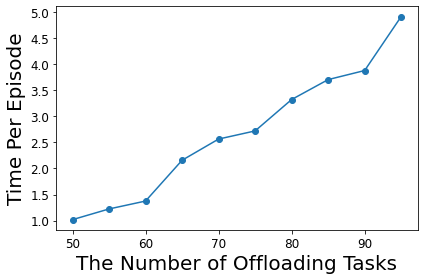

In [ ]:
k=np.arange(50,96,5)
time_count=[1.018019199371338, 1.2231674194335938, 1.3748435974121094, 2.1571991443634033, 2.5641987323760986, 2.720216941833496, 3.3223206996917725, 3.7048656940460205, 3.8788836002349854, 4.914473056793213]
plt.plot(k,time_count,'o',markevery=1,ls='-')
#plt.plot(k,b/10,'o',markevery=1,ls='-',label='Without')
plt.xlabel("The Number of Offloading Tasks",fontsize=20) 
plt.ylabel("Time Per Episode",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test_task.pdf')
plt.show()

No handles with labels found to put in legend.


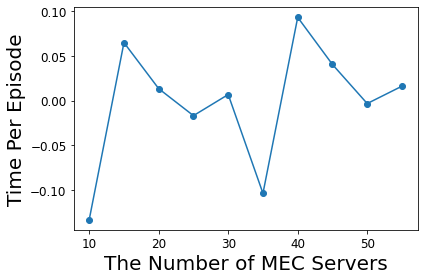

In [ ]:
speed_up=(np.array(time_without)-np.array(time_count))/np.array(time_without)

k=np.arange(10,56,5)
#random_r=[19154, 18976, 21162, 20471, 21880, 20844]
#greedy_r=[27060, 27168, 27561, 27074, 26962, 27312]
#q_r=[28236, 28094, 28350, 28358, 28147, 28218]
plt.plot(k,speed_up,'o',markevery=1,ls='-')
#plt.plot(k,b/10,'o',markevery=1,ls='-',label='Without')
plt.xlabel("The Number of MEC Servers",fontsize=20) 
plt.ylabel("Time Per Episode",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test_server.pdf')
plt.show()

In [ ]:
num_server=60#number of servers
num_task=100#number of tasks
EPSILON=0.9 # greedy
GAMMA=0.9 #discount
ALPHA=0.01 #learning rate
max_iteration=1#iterations
  #generate data
data=DataCollection()
p=data.generate_random_value(1,10,num_task) #price
D=data.generate_random_value(10,20,num_task) #data size
T=data.generate_random_value(1,100,num_task) #time
task=data.generate_task(p,D,T,num_task) #tasks
task=np.array(task) 
ser_task=data.generate_group(num_task,num_server) #server-class group
server=data.generate_server(200,400,num_server) #server
f_j=data.generate_random_value(1,10,num_server) #CPU frequency
d_i=data.generate_random_value(1,10,num_server)
alpha=0.00001
B=data.generate_random_value(5,10,num_server)
P_i=data.generate_random_value(5,10,num_server)
G_i=data.generate_random_value(5,10,num_server)
delta=0.001
R_i_j=[]
for i in range(num_server):
  R=B[i]*math.log(1+(P_i[i]*G_i[i])/delta**2)
  R_i_j.append(R)
#training
#self,f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta, task,server,ser_task,ALPHA,GAMMA,EPSILON,MAX_EPISODES
ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,max_iteration)
#random
max_random=ql.ramdom_select()
print(max_random)
#greedy
max_greedy=ql.greedy_select()
print(max_greedy)
#q_learning
#print(solution)
#print(max_reward)
#print(res)

54212
68070


In [ ]:
#with speed up
time_start=time.time()
max_reward,solution,q_table,res=ql.training()
solution=np.array(solution)
time_end=time.time()
time_cost=time_end-time_start
print(time_cost/max_iteration)
print(max_reward)

2.72287917137146
30881


In [ ]:
#without speed up
time_start=time.time()
ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,1)
max_reward,solution,q_table,res=ql.training_without_speed_up()
solution=np.array(solution)
time_end=time.time()
time_cost=time_end-time_start
print(time_cost/max_iteration)
print(max_reward)

2.91331148147583
30747


In [ ]:
#without speed up
num_server=20#number of servers
num_task=50#number of tasks
EPSILON=0.9 # greedy
GAMMA=0.9 #discount
ALPHA=0.01 #learning rate
max_iteration=500#iterations
#generate data
data=DataCollection()
p=data.generate_random_value(1,10,num_task) #price
D=data.generate_random_value(10,20,num_task) #data size
T=data.generate_random_value(1,100,num_task) #time
task=data.generate_task(p,D,T,num_task) #tasks
task=np.array(task) 
ser_task=data.generate_group(num_task,num_server) #server-class group
server=data.generate_server(200,400,num_server) #server
f_j=data.generate_random_value(1,10,num_server) #CPU frequency
d_i=data.generate_random_value(1,10,num_server)
alpha=0.00001
B=data.generate_random_value(5,10,num_server)
P_i=data.generate_random_value(5,10,num_server)
G_i=data.generate_random_value(5,10,num_server)
delta=0.001
R_i_j=[]
for i in range(num_server):
  R=B[i]*math.log(1+(P_i[i]*G_i[i])/delta**2)
  R_i_j.append(R)

ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,max_iteration)
time_start=time.time()
max_reward,solution,q_table,res=ql.training_without_speed_up()
solution=np.array(solution)
time_end=time.time()
time_cost=time_end-time_start
print(time_cost/500)

2.1479482650756836


In [ ]:
task_1=pd.DataFrame(task)
task_1.to_csv('task.csv')
server_1=pd.DataFrame(server)
server_1.to_csv('server.csv')
f_1=pd.DataFrame(f_j)
f_1.to_csv('f_j.csv')
d_1=pd.DataFrame(d_i)
d_1.to_csv('d_i.csv')
B_1=pd.DataFrame(B)
B_1.to_csv('B.csv')
P_1=pd.DataFrame(P_i)
P_1.to_csv('P_i.csv')
G_1=pd.DataFrame(G_i)
G_1.to_csv('G_i.csv')
R_1=pd.DataFrame(R_i_j)
R_1.to_csv('R_i_j.csv')

In [ ]:
print(server)
print(server[0:10])
ser_task=data.generate_group(num_task,10)
print(ser_task)
print(G_i[0:10])

[278, 250, 263, 292, 220, 271, 222, 392, 314, 223, 366, 347, 364, 286, 258, 299, 278, 210, 283, 247, 281, 348, 277, 262, 285, 225, 339, 356, 348, 352, 223, 262, 256, 205, 262, 302, 218, 268, 341, 218, 386, 219, 205, 362, 202, 274, 392, 291, 326, 320, 239, 225, 328, 399, 283, 219, 330, 370, 244, 245]
[278, 250, 263, 292, 220, 271, 222, 392, 314, 223]
[[3, 36, 6, 88, 83, 57, 11, 9, 96, 53], [80, 71, 58, 42, 19, 47, 89, 72, 33, 1], [99, 44, 32, 75, 70, 74, 55, 34, 90, 59], [40, 25, 66, 54, 84, 20, 93, 38, 0, 77], [79, 49, 78, 64, 62, 21, 16, 45, 61, 86], [60, 37, 69, 73, 18, 52, 68, 92, 10, 48], [24, 65, 31, 85, 94, 28, 81, 22, 15, 35], [43, 97, 67, 82, 4, 27, 2, 76, 7, 5], [23, 12, 63, 41, 50, 29, 13, 8, 95, 87], [26, 98, 14, 30, 51, 39, 46, 56, 91, 17]]
[9, 9, 8, 10, 10, 7, 10, 6, 8, 9]


In [ ]:
num_s=[10,20,30,40,50,60]
num_t=[50,60,70,80,90,100]
random_r=[]
greedy_r=[]
q_r=[]
rew=[]
solutions=[]
time_c=[]
num_task=50
task=task[0:50]
for num_server in num_s:
  f_j=f_j[0:num_server]
  d_i=d_i[0:num_server]
  B=B[0:num_server]
  P_i=P_i[0:num_server]
  G_i=G_i[0:num_server]
  R_i_j=R_i_j[0:num_server]

  server=server[0:num_server]
  ser_task=data.generate_group(num_task,num_server)
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,500)
  #random
  max_random=ql.ramdom_select()

  max_greedy=ql.greedy_select()

  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  time_end=time.time()
  time_cost=time_end-time_start

  solution=np.array(solution)

  random_r.append(max_random)
  greedy_r.append(max_greedy)
  q_r.append(max_reward)
  rew.append(res)
  time_c.append(time_cost/500)
  solutions.append(solution)
  print(num_server)



10
20
30
40
50
60


In [ ]:
print(random_r)
print(greedy_r)
print(q_r)
print(time_c)

#re=pd.DataFrame(rew)
#re.to_csv('res_1.csv')

[19721, 20393, 23287, 23709, 22047, 21991]
[31780, 30699, 31668, 31779, 31326, 31342]
[34794, 34794, 34794, 34794, 34784, 34794]
[1.0189970507621766, 1.0102974405288696, 0.9913499879837037, 1.0211333951950072, 1.024064868927002, 1.0184893527030945]


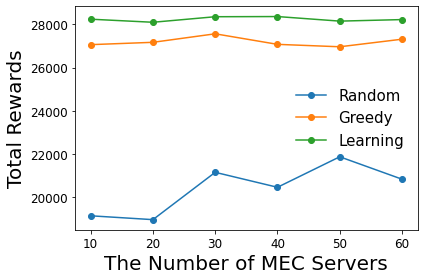

In [ ]:
#utility with the change of number of servers
k=np.arange(10,61,10)
random_r=[19154, 18976, 21162, 20471, 21880, 20844]
greedy_r=[27060, 27168, 27561, 27074, 26962, 27312]
q_r=[28236, 28094, 28350, 28358, 28147, 28218]
plt.plot(k,random_r,'o',markevery=1,ls='-',label='Random')
plt.plot(k,greedy_r,'o',markevery=1,ls='-',label='Greedy')
plt.plot(k,q_r,'o',markevery=1,ls='-',label='Learning')
plt.xlabel("The Number of MEC Servers",fontsize=20)
plt.ylabel("Total Rewards",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test2.pdf')
plt.show()

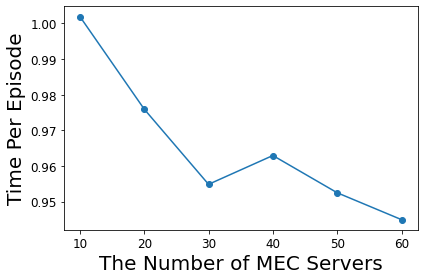

In [ ]:
#utility with the change of number of servers
k=np.arange(10,61,10)
#time=[0.735521656036377, 0.7081901774406433, 0.7134249806404114, 0.7075693793296814, 0.6968437833786011, 0.6984841341972351]

plt.plot(k,time_c,'o',markevery=1,ls='-')

plt.xlabel("The Number of MEC Servers",fontsize=20)
plt.ylabel("Time Per Episode",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
#plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test3.pdf')
plt.show()

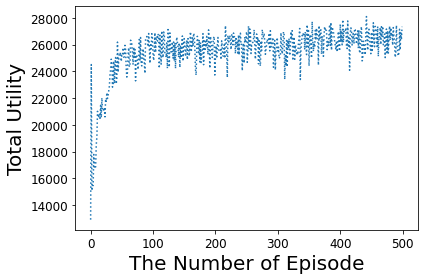

In [ ]:
k=np.arange(0,500,1)

plt.plot(k,rew[1],ls='dotted')


plt.xlabel("The Number of Episode",fontsize=20)
plt.ylabel("Total Utility",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
#plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test4.pdf')
plt.show()

In [ ]:
num_s=[10,20,30,40,50,60]
num_t=[50,60,70,80,90,100]
random_r=[]
greedy_r=[]
q_r=[]
rew=[]
solutions=[]
time_c=[]
num_server=20
#task=task[0:50]

f_j=f_j[0:num_server]
d_i=d_i[0:num_server]
B=B[0:num_server]
P_i=P_i[0:num_server]
G_i=G_i[0:num_server]
R_i_j=R_i_j[0:num_server]

server=server[0:num_server]
#ser_task=data.generate_group(num_task,num_server)
for num_task in num_t:

  task=task[0:num_task]

  ser_task=data.generate_group(num_task,num_server)

  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,500)
  #random
  max_random=ql.ramdom_select()

  max_greedy=ql.greedy_select()

  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  time_end=time.time()
  time_cost=time_end-time_start

  solution=np.array(solution)

  random_r.append(max_random)
  greedy_r.append(max_greedy)
  q_r.append(max_reward)
  rew.append(res)
  time_c.append(time_cost/500)
  solutions.append(solution)
  print(num_task)

50
60
70
80
90
100


In [ ]:
print(random_r)
print(greedy_r)
print(q_r)
print(time_c)

[24277, 22966, 23314, 24768, 23083, 24676]
[32370, 33134, 32886, 32687, 33134, 32726]
[35466, 35581, 35509, 35441, 35238, 35379]
[0.9742456860542298, 0.9728624849319458, 0.9828785362243653, 0.9932622990608215, 0.9982113742828369, 1.0009148449897767]


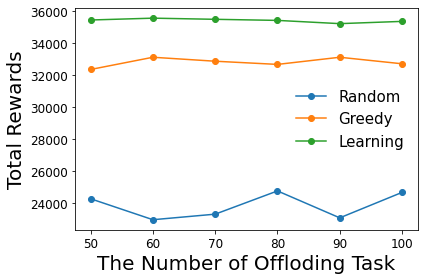

In [ ]:
#utility with the change of number of tasks
k=np.arange(50,101,10)

random_r=[24277, 22966, 23314, 24768, 23083, 24676]
greedy_r=[32370, 33134, 32886, 32687, 33134, 32726]
q_r=[35466, 35581, 35509, 35441, 35238, 35379]

plt.plot(k,random_r,'o',markevery=1,ls='-',label='Random')
plt.plot(k,greedy_r,'o',markevery=1,ls='-',label='Greedy')
plt.plot(k,q_r,'o',markevery=1,ls='-',label='Learning')
plt.xlabel("The Number of Offloding Task",fontsize=20)
plt.ylabel("Total Rewards",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test5.pdf')
plt.show()

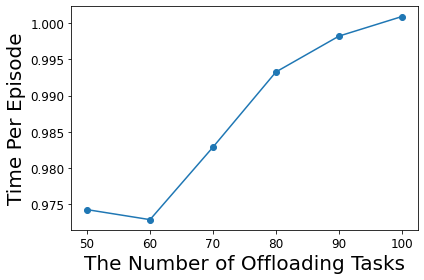

In [ ]:
#utility with the change of number of servers
k=np.arange(50,101,10)
time=[1.8359399328231811, 1.8494439606666564, 1.8560907225608825, 1.8537465558052062, 1.8476771593093873, 1.853216139316559]

plt.plot(k,time_c,'o',markevery=1,ls='-')

plt.xlabel("The Number of Offloading Tasks",fontsize=20)
plt.ylabel("Time Per Episode",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
#plt.legend(fontsize=15,framealpha=0)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test6.pdf')
plt.show()

In [ ]:
#test the inluence of alpha on the convergence
ALP=[0.1,0.5,0.9]
GAM=[0.1,0.5,0.9]
EPS=[0.1,0.5,0.9]

random_r=[]
greedy_r=[]
q_r=[]
rew=[]
solutions=[]
time_c=[]
num_server=20
num_task=20
#task=task[0:50]

f_j=f_j[0:num_server]
d_i=d_i[0:num_server]
B=B[0:num_server]
P_i=P_i[0:num_server]
G_i=G_i[0:num_server]
R_i_j=R_i_j[0:num_server]

server=server[0:num_server]
task=task[0:num_task]

ser_task=data.generate_group(num_task,num_server)

for ALPHA in ALP:
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,500)
  #random
  max_random=ql.ramdom_select()

  max_greedy=ql.greedy_select()

  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  time_end=time.time()
  time_cost=time_end-time_start

  solution=np.array(solution)

  random_r.append(max_random)
  greedy_r.append(max_greedy)
  q_r.append(max_reward)
  rew.append(res)
  time_c.append(time_cost/500)
  solutions.append(solution)
  print(ALPHA)



0.1
0.5
0.9


In [ ]:
print(random_r)
print(greedy_r)
print(q_r)
print(time_c)

[9133.0, 8620.0, 10681.0]
[12900.0, 12780.0, 12478.0]
[16138.726021001636, 16078.726021001636, 16094.726021001636]
[0.1889845471382141, 0.1915898127555847, 0.18877474689483642]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


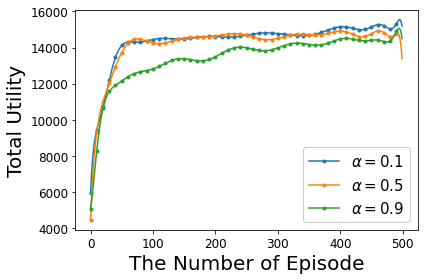

In [ ]:
k=np.arange(0,500,1)

f1 = np.polyfit(k, rew[0], 20)
p1 = np.poly1d(f1)
yvals1 = p1(k)

f2 = np.polyfit(k, rew[1], 20)
p2 = np.poly1d(f2)
yvals2 = p2(k)

f3 = np.polyfit(k, rew[2], 20)
p3 = np.poly1d(f3)
yvals3 = p3(k)

plt.plot(k, yvals1,'.-',markevery=10,label=r'$\alpha=0.1$')
plt.plot(k, yvals2,'.-',markevery=10,label=r'$\alpha=0.5$')
plt.plot(k, yvals3,'.-',markevery=10,label=r'$\alpha=0.9$')

#plt.plot(k,rew[0],'.',markevery=1,label=r'$\alpha=0.1$')
#plt.plot(k,rew[1],'.',markevery=1,label=r'$\alpha=0.5$')
#plt.plot(k,rew[2],'.',markevery=1,label=r'$\alpha=0.9$')


plt.xlabel("The Number of Episode",fontsize=20)
plt.ylabel("Total Utility",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=1)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test7.pdf')
plt.show()

In [ ]:
#test the inluence of alpha on the convergence
ALP=[0.1,0.5,0.9]
GAM=[0.1,0.5,0.9]
EPS=[0.1,0.5,0.9]

random_r=[]
greedy_r=[]
q_r=[]
rew=[]
solutions=[]
time_c=[]
num_server=20
num_task=20
ALPHA=0.01
EPSILON=0.9
#task=task[0:50]

f_j=f_j[0:num_server]
d_i=d_i[0:num_server]
B=B[0:num_server]
P_i=P_i[0:num_server]
G_i=G_i[0:num_server]
R_i_j=R_i_j[0:num_server]

server=server[0:num_server]
task=task[0:num_task]

ser_task=data.generate_group(num_task,num_server)

for GAMMA in GAM:
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,500)
  #random
  max_random=ql.ramdom_select()

  max_greedy=ql.greedy_select()

  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  time_end=time.time()
  time_cost=time_end-time_start

  solution=np.array(solution)

  random_r.append(max_random)
  greedy_r.append(max_greedy)
  q_r.append(max_reward)
  rew.append(res)
  time_c.append(time_cost/500)
  solutions.append(solution)
  print(GAMMA)

0.1
0.5
0.9


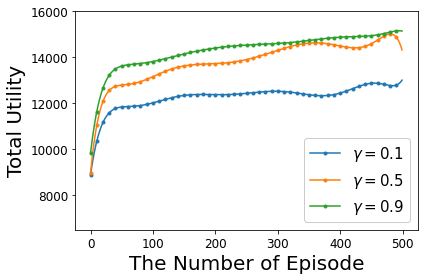

In [ ]:
k=np.arange(0,500,1)

f1 = np.polyfit(k, rew[0], 10)
p1 = np.poly1d(f1)
yvals1 = p1(k)

f2 = np.polyfit(k, rew[1], 10)
p2 = np.poly1d(f2)
yvals2 = p2(k)

f3 = np.polyfit(k, rew[2], 10)
p3 = np.poly1d(f3)
yvals3 = p3(k)

plt.plot(k, yvals1,'.-',markevery=10,label=r'$\gamma=0.1$')
plt.plot(k, yvals2,'.-',markevery=10,label=r'$\gamma=0.5$')
plt.plot(k, yvals3,'.-',markevery=10,label=r'$\gamma=0.9$')

#plt.plot(k,rew[0],'.',markevery=1,label=r'$\gamma=0.1$')
#plt.plot(k,rew[1],'.',markevery=1,label=r'$\gamma=0.5$')
#plt.plot(k,rew[2],'.',markevery=1,label=r'$\gamma=0.9$')


plt.xlabel("The Number of Episode",fontsize=20)
plt.ylabel("Total Utility",fontsize=20)
plt.ylim(6500,16000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=1,loc='best')
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test_8.pdf')
plt.show()

In [ ]:
#test the inluence of alpha on the convergence
ALP=[0.1,0.5,0.9]
GAM=[0.1,0.5,0.9]
EPS=[0.1,0.5,0.9]

random_r=[]
greedy_r=[]
q_r=[]
rew=[]
solutions=[]
time_c=[]
num_server=20
num_task=20
ALPHA=0.01
GAMMA=0.9

#task=task[0:50]

f_j=f_j[0:num_server]
d_i=d_i[0:num_server]
B=B[0:num_server]
P_i=P_i[0:num_server]
G_i=G_i[0:num_server]
R_i_j=R_i_j[0:num_server]

server=server[0:num_server]
task=task[0:num_task]

ser_task=data.generate_group(num_task,num_server)

for EPSILON in EPS:
  ql=Task_allocation(f_j, d_i, alpha, B, P_i, G_i, R_i_j,delta,task,server,ser_task,EPSILON,ALPHA,GAMMA,500)
  #random
  max_random=ql.ramdom_select()

  max_greedy=ql.greedy_select()

  time_start=time.time()
  max_reward,solution,q_table,res=ql.training()
  time_end=time.time()
  time_cost=time_end-time_start

  solution=np.array(solution)

  random_r.append(max_random)
  greedy_r.append(max_greedy)
  q_r.append(max_reward)
  rew.append(res)
  time_c.append(time_cost/500)
  solutions.append(solution)
  print(EPSILON)

0.1
0.5
0.9


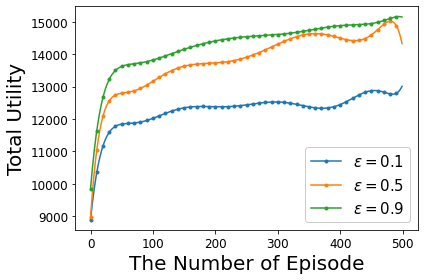

In [ ]:
k=np.arange(0,500,1)

f1 = np.polyfit(k, rew[0], 10)
p1 = np.poly1d(f1)
yvals1 = p1(k)

f2 = np.polyfit(k, rew[1], 10)
p2 = np.poly1d(f2)
yvals2 = p2(k)

f3 = np.polyfit(k, rew[2], 10)
p3 = np.poly1d(f3)
yvals3 = p3(k)

plt.plot(k, yvals1,'.-',markevery=10,label=r'$\epsilon=0.1$')
plt.plot(k, yvals2,'.-',markevery=10,label=r'$\epsilon=0.5$')
plt.plot(k, yvals3,'.-',markevery=10,label=r'$\epsilon=0.9$')

#plt.plot(k,rew[0],'.',markevery=1,label=r'$\epsilon=0.1$')
#plt.plot(k,rew[1],'.',markevery=1,label=r'$\epsilon=0.5$')
#plt.plot(k,rew[2],'.',markevery=1,label=r'$\epsilon=0.9$')


plt.xlabel("The Number of Episode",fontsize=20)
plt.ylabel("Total Utility",fontsize=20)
#plt.ylim(18000,32000)
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize=15,framealpha=1)
plt.tight_layout()
#plt.legend(handles=[l1,l2,l3,l4],labels=['0.1','0.4','0.4','0.4'],loc='best')
plt.savefig('./test_9.pdf')
plt.show()